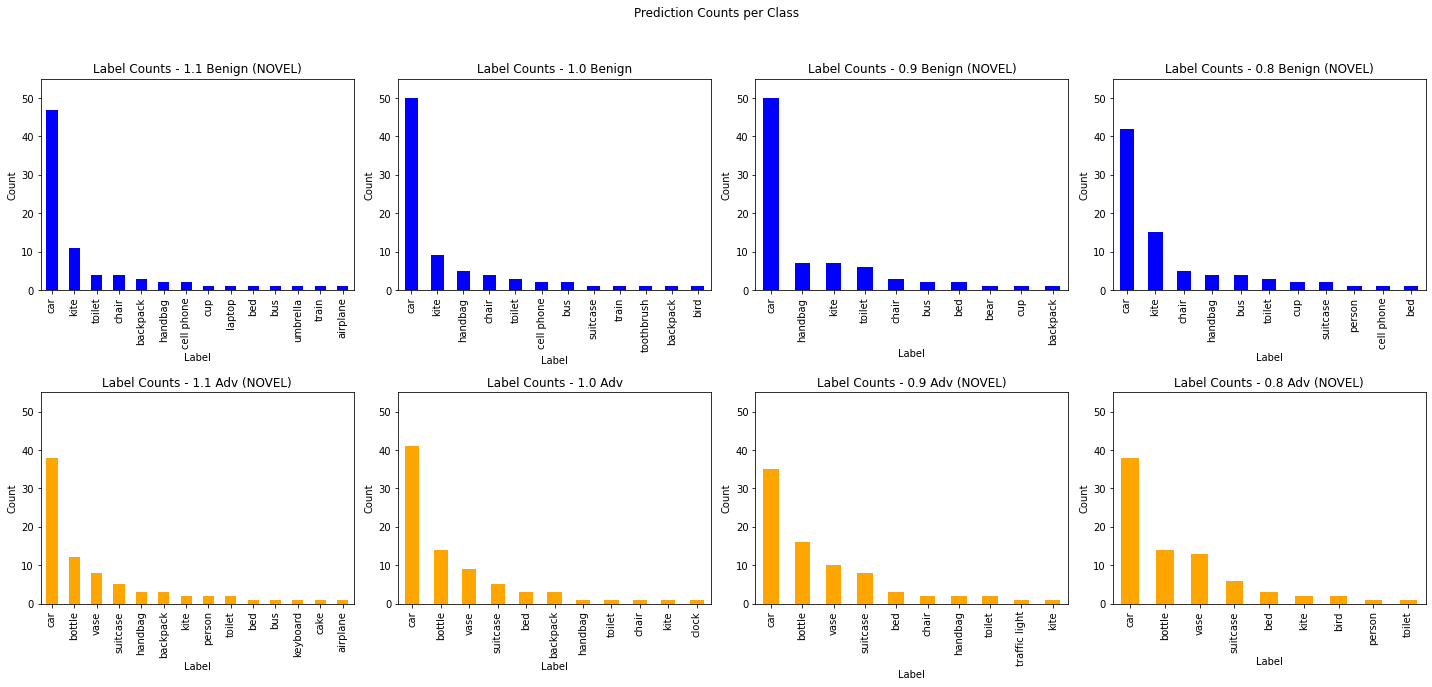

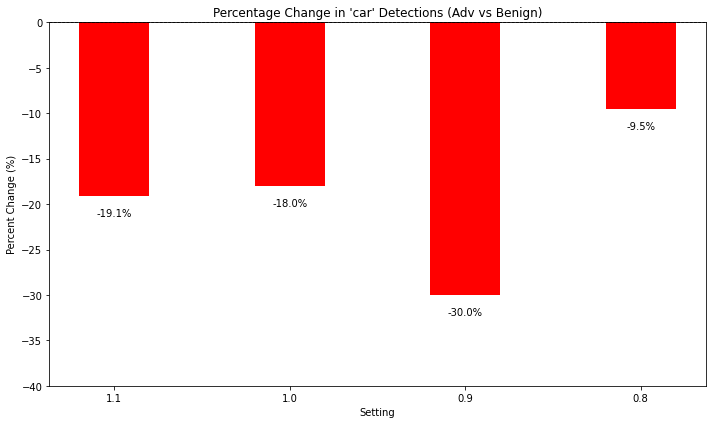

In [18]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the render.log files
log_path = "/raid/mhull32/3D-Gaussian-Splat-Attack/results/maserati/2025-04-06"
paths = [
    "nyc_block_1_1_benign_dt2","nyc_block_1_0_benign_dt2", 
    "nyc_block_0_9_benign_dt2","nyc_block_0_8_benign_dt2", 
    "nyc_block_1_1_adv_dt2","nyc_block_1_0_adv_dt2",
    "nyc_block_0_9_adv_dt2","nyc_block_0_8_adv_dt2"
]
titles = [
    "1.1 Benign (NOVEL)","1.0 Benign","0.9 Benign (NOVEL)","0.8 Benign (NOVEL)", "1.1 Adv (NOVEL)", "1.0 Adv","0.9 Adv (NOVEL)","0.8 Adv (NOVEL)", 
]

full_paths = [os.path.join(log_path, p, "render.log") for p in paths]

pattern = re.compile(r"max_iou_pred: ([\w\s]+), conf: ([\d\.]+|None)")
dfs = []

# Parse all logs into dataframes
for path in full_paths:
    labels, confidences = [], []
    cam_count = 0
    with open(path, 'r') as f:
        for line in f:
            if cam_count >= 80:
                break
            match = pattern.search(line)
            if match:
                label = match.group(1)
                conf = match.group(2)
                if conf != "None":
                    labels.append(label)
                    confidences.append(float(conf))
                    cam_count += 1
    df = pd.DataFrame({"label": labels, "confidence": confidences})
    dfs.append(df)

# Plot 1: Count of predictions per class (2 rows x 4 cols)
fig1, axs1 = plt.subplots(2, 4, figsize=(20, 10))
for i, (df, title) in enumerate(zip(dfs, titles)):
    ax = axs1[i // 4, i % 4]
    color = 'orange' if 'Adv' in title else 'blue'
    df["label"].value_counts().plot(kind="bar", ax=ax, color=color)
    ax.set_title(f"Label Counts - {title}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_ylim(0, 55)
fig1.suptitle("Prediction Counts per Class")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # Plot 2: Histogram of 'car' confidences (2 rows x 4 cols)
# fig2, axs2 = plt.subplots(2, 4, figsize=(20, 10))
# for i, (df, title) in enumerate(zip(dfs, titles)):
#     ax = axs2[i // 4, i % 4]
#     color = 'orange' if 'Adv' in title else 'blue'
#     car_conf = df[df["label"] == "car"]["confidence"]
#     if not car_conf.empty:
#         car_conf.hist(bins=20, ax=ax, color=color)
#     ax.set_title(f"'car' Conf - {title}")
#     ax.set_xlabel("Confidence")
#     ax.set_ylabel("Frequency")
#     ax.set_ylim(0, 50)
# fig2.suptitle("Confidence Histogram for 'car'")
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Compute percentage drop or increase in 'car' detections for each setting
percent_changes = []
labels_summary = ["1.1", "1.0", "0.9", "0.8"]

for i in range(4):
    benign_count = dfs[i]["label"].value_counts().get("car", 0)
    adv_count = dfs[i + 4]["label"].value_counts().get("car", 0)
    if benign_count == 0:
        change = 0  # or float('nan')
    else:
        change = ((adv_count - benign_count) / benign_count) * 100
    percent_changes.append(change)

# Plot the percentage changes
fig3, ax3 = plt.subplots(figsize=(10, 6))
bars = ax3.bar(labels_summary, percent_changes, width=0.4, color=['green' if x >= 0 else 'red' for x in percent_changes])
ax3.set_title("Percentage Change in 'car' Detections (Adv vs Benign)")
ax3.set_ylabel("Percent Change (%)")
ax3.set_xlabel("Setting")
ax3.set_ylim(-40, 0)
ax3.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3 if height >= 0 else -12),
                 textcoords="offset points",
                 ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()